# FRMOD basics - 1

Import the necessary modules from the frmod package.

In [1]:
from frmod.analysis import VRaster, LandslideMask, FRAnalysis, show_grid

Create the VRaster and LandslideMask objects.
VRaster objects store the data related to the analyzed variables.
LandslideMask objects store the data for the mask. The mask is used to separate the landslide and the non-landslide areas. 

In [2]:
elevation = VRaster(name='elevation',
                    path='./data/SRTM31_EG_GF_m.sdat',
                    bins=20,
                    categorical=False)
slope = VRaster(name='slope',
                path='./data/SRTM31_EG_GF_Slope_m.sdat',
                bins=10,
                categorical=False)
geology = VRaster(name='geology_14',
                  path='./data/fdt100_14k.sdat',
                  categorical=True)
scarps = LandslideMask(name='scarps',
                       path='./data/scarps.sdat',
                       ls_marker=1,
                       fold_count=5)

Plot the grid of the elevation VRaster along with its basic statistics.

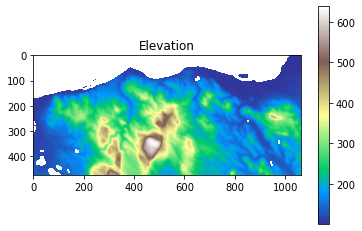

Name: elevation Limits: (100.67122, 638.9841)
Mean: 219.7329864501953 Standard deviation: 95.92752838134766


In [3]:
show_grid(elevation.grid, nodata=elevation.nodata, name='Elevation', cmap='terrain')
elevation.show_info()

Create the FRAnalysis object and run the analysis.

In [4]:
fra = FRAnalysis(ls_mask=scarps,
                 var_list=[slope,
                           geology,
                           elevation]
                 )

In [5]:
result_percentile_bins = fra.get_result()

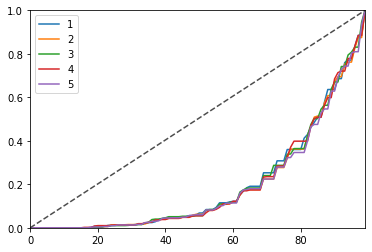

In [6]:
success_rates = fra.get_src()
fra.plot_success_rates()

In [7]:
auc_folds = fra.get_auc()

Auc: 19.627000000000006
Auc: 19.152
Auc: 19.503503503503506
Auc: 19.35435435435435
Auc: 18.90990990990991
Mean score: 19.309353553553557; Std: 0.2549250499035282


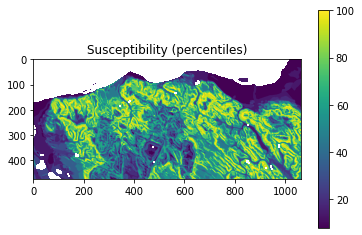

In [8]:
fra.get_percentile_grid(show=True)

             min        max  LS_density  NLS_density  frequency_ratio
count  10.000000  10.000000   10.000000    10.000000        10.000000
mean   14.690514  17.954859    0.100000     0.100000         1.040166
std     9.883299   9.883299    0.151825     0.139003         0.863038
min     0.000957   3.265303    0.000000     0.000126         0.000000
25%     7.345736  10.610081    0.003815     0.002995         0.235432
50%    14.690514  17.954860    0.018139     0.023107         0.947974
75%    22.035293  25.299638    0.141981     0.163271         1.721278
max    29.380072  32.644417    0.426820     0.373466         2.234004


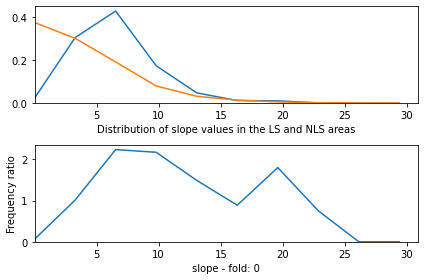

In [9]:
fra.plot_var_fold_fr("slope", 0)